In [143]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
import os
from tqdm.auto import tqdm

<h1>Visual Evaluation of Winning Recommendation Systems</h1>
<ul>
    <li>Convolutional Neural Network Based Recommender</li>
    <li>Binary Vectorization Based Recommender</li>
    
</ul>

In [145]:
articles_df = pd.read_csv("../datasets/articles_transactions_5.csv")
articles_df.shape

(26722, 26)

In [146]:
articles_df = pd.read_csv("../datasets/articles_transactions_5.csv")
i = articles_df.copy()
i['detail_desc'] = i['detail_desc'].fillna("")
t = pd.read_csv("../datasets/transactions_5.csv")
fashion_classifier = load_model("../Weights/cnn3_new.h5")
embeddings_df = pd.read_csv('../Datasets/col_cnn_embeddings.csv')
cnn_cosine = cosine_similarity(embeddings_df.drop('image',axis=1))
images = embeddings_df['image'].values
cnn_cosine_df = pd.DataFrame(cnn_cosine, columns=images, index=images)

In [147]:
count_vectorizer = CountVectorizer(binary=True,stop_words = "english")
profiles= count_vectorizer.fit_transform(i["detail_desc"])
cosine_sim_count  = cosine_similarity(profiles)
cosine_count_df = pd.DataFrame(cosine_sim_count, columns=i['article_id'], index=i['article_id'])

In [148]:
test_t = pd.read_csv('../datasets/test_set_transac_5_u_1500.csv')
test_u = test_t['customer_id'].drop_duplicates()

In [149]:
def load_image(path):
    tar_image = load_img(path,target_size=(28, 28), color_mode ='grayscale') # trousers
    img_array = img_to_array(tar_image) # Image Tensor
    img_array = np.array([img_array]) 
    return img_array
def show_image(items_list):
    image_list = []
    
    for item_id in items_list:
        cls = i['product_type_name'][i['article_id'] == item_id].values[0]
        path = f'../datasets/images/{cls.replace("/","")}/0{item_id}.jpg'
        if os.path.exists(path):
            tar_image = load_img(path,target_size=(224, 224)) 
            image_list.append(tar_image)

    x,ax = plt.subplots(1,len(image_list),figsize=(224,224))
    plt.figure()
    for k,val in enumerate(image_list):
        ax[k].imshow(val)
    return 

In [150]:

def cnn_recommender(customer):
    default_vals = cnn_cosine_df[775310002].sort_values(ascending=False).head(1)
    default_vals.iloc[0] = 0.0
    all_i_df = pd.DataFrame()
    all_i_df = pd.concat([all_i_df,default_vals])
    customer_purchases = t['article_id'][t['customer_id'] == customer].drop_duplicates().values
    for item in customer_purchases:
        cls = i['product_type_name'][i['article_id'] == item].values[0]
        if os.path.exists(f'../datasets/images/{cls.replace("/","")}/0{item}.jpg'):
            similar_imgs = cnn_cosine_df[item].sort_values(ascending=False)
            all_i_df = pd.concat([all_i_df,similar_imgs.nlargest(6)])[1:] 
    return all_i_df[0].nlargest(6)
def content_based_recommender_count(customer):
    all_items = pd.DataFrame()
    customer_purchases = t['article_id'][t['customer_id'] == customer].drop_duplicates().values
    for item in customer_purchases:
        sim_i = cosine_count_df[item].sort_values(ascending=False)
        all_items = pd.concat([all_items,sim_i.nlargest(6)])[1:]
    return all_items[0].nlargest(6)

In [151]:
test_t['customer_id'].value_counts().nlargest(15)

208abedfe52d75a401a5a80eea5e64ace6ea3f1dfcc2348ee51e30d9da2b8191    15
37c5c5c100cc6de302161d9fc04985f1fcf1ce9189f5306680ea2df6fae6deb3    10
88e72ef4a0c7f975ba941a693031aa98721de5d8c1ee25e1b8efaeac67a8d8c1    10
94bdb4e54497f58c0f6dbe2d772f6197b589619c71b117a9269fe722cdea884e    10
ebd34b1848491d5c82026c07311e0120824b5c3830c3b0a092813c8d9b99209b     9
e97b597ebc5bf16a49c79dc8bdb2aa071ed2e3e4b125e5fbc58e5bba9c264da0     8
3f6e50963bfcac5a7c709384d5cb9ec864875ef389a2f3837c037836cf159916     8
ee2aaee936f3c4d870db5bda7583a66741e120fdfa9c44e4a84d5263412d6f5b     8
1f28c6a23abf5a82bd8fa88b2e207af16983b163aef8991d346f08e1383e8bfe     8
146c9015572625359838a4fea0ba263d73d291d51b51a0a5d38a410bbece2f02     7
7ee82aa234ac383a2d687a98d5c75bc0e51f4cefebd843f33c2383d83282d9c5     7
4266179bde4f810ac0b5697be2751832ab399226d8a42e45b60fe5bc6fa93242     7
8db63da231ee901d7b7b1528a5e45ae52bc5fb86cf9104fbc18521bba8176763     7
166ff7875b7b0aebf11eb797a2580c9d898ceada9a597110348172fe9eb0adb9     6
120c5a

In [142]:
# ID = '8db63da231ee901d7b7b1528a5e45ae52bc5fb86cf9104fbc18521bba8176763'
# p = test_t[test_t['customer_id'] == ID]['article_id'].drop_duplicates().values
# print(f'Total number of transactions for this customer in the test set: {len(p)}')

Total number of transactions for this customer in the test set: 7


In [152]:
c = '8db63da231ee901d7b7b1528a5e45ae52bc5fb86cf9104fbc18521bba8176763'
cnn_rec = cnn_recommender(c).index.values 
bv_rec = content_based_recommender_count(c).index.values
u_purchases = test_t[test_t['customer_id'] == c]['article_id'].drop_duplicates().values
u_purchases = u_purchases.tolist()

In [154]:
print(len(u_purchases))
print('user purchases : ',u_purchases)
print('cnn : ', cnn_rec)
print('bv : ', bv_rec)

7
user purchases :  [683001019, 902265001, 922037002, 536139006, 881117001, 925124001, 875072004]
cnn :  [536139006 875272012 922037002 875072004 568808001 751471001]
bv :  [881117001 881117002 872075001 904423001 759814034 759814010]


In [112]:
# display_purc = '' # we know the user has 15 purchases and the if statement below will definately run
# if len(u_purchases) > 8:
#     display_purc = np.random.choice(u_purchases,6)

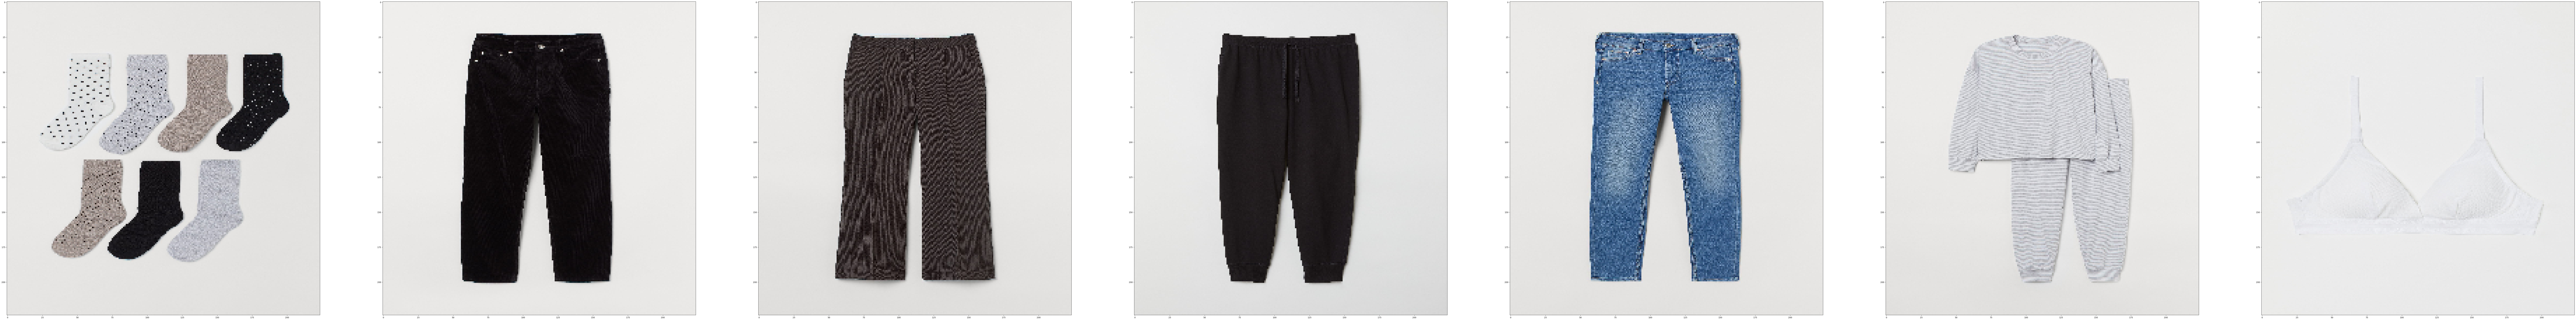

<Figure size 640x480 with 0 Axes>

In [155]:
show_image(u_purchases)

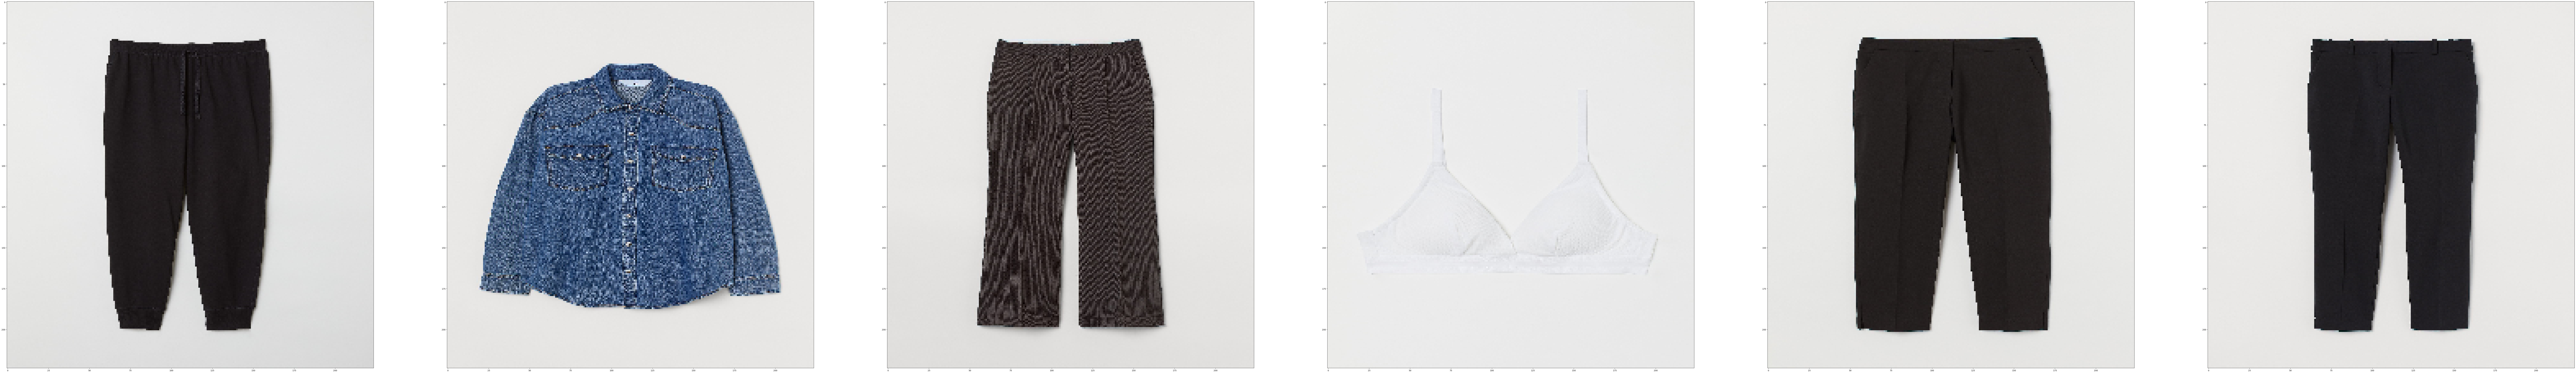

<Figure size 640x480 with 0 Axes>

In [156]:
show_image(cnn_rec)

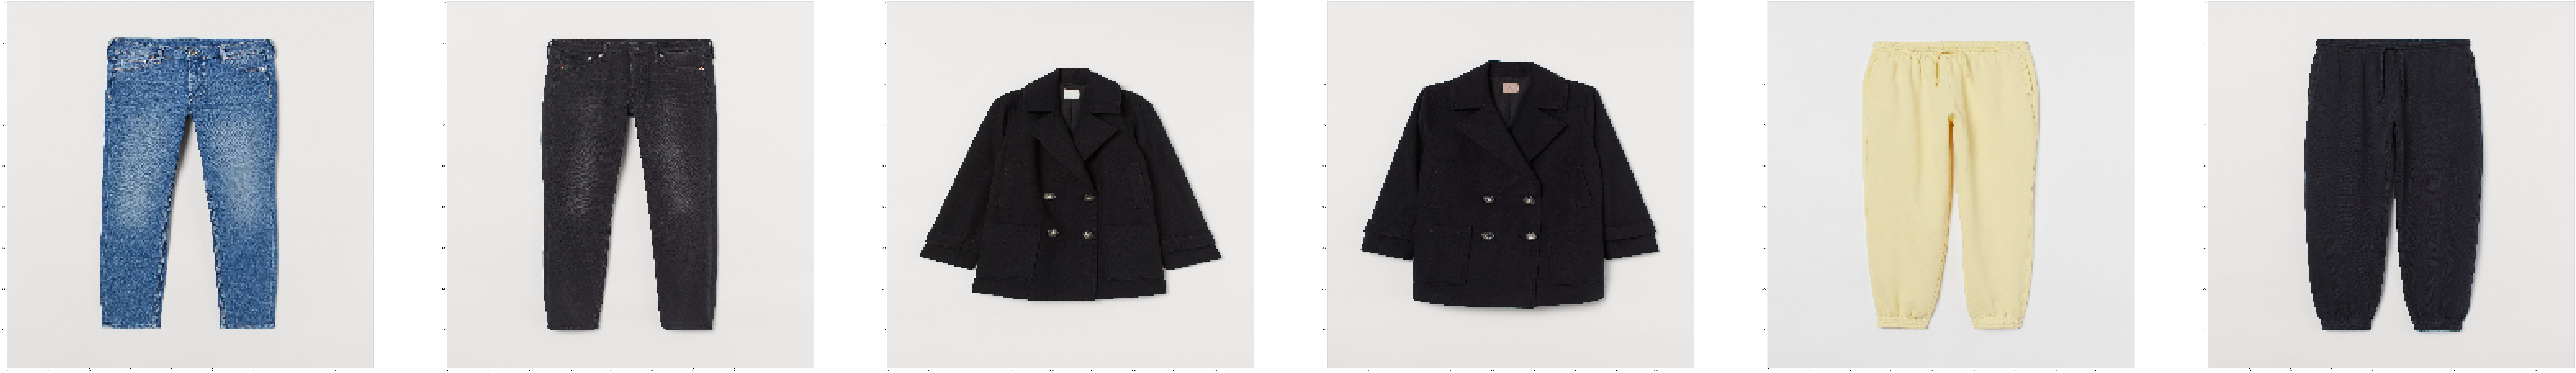

<Figure size 640x480 with 0 Axes>

In [157]:
show_image(bv_rec)

In [140]:
precision_list_count = []
precision_list_cnn = []

cnn_rec = cnn_recommender(c).index.values
count_rec = content_based_recommender_count(c).index.values
print(len(np.intersect1d(count_rec,u_purchases)))
print(len(np.intersect1d(cnn_rec,u_purchases)))
precision_list_count.append(len(np.intersect1d(count_rec,u_purchases))/len(count_rec))
precision_list_cnn.append(len(np.intersect1d(cnn_rec,u_purchases))/len(cnn_rec))
print("MEAN Precison of Binary vector based Recommender",np.mean(precision_list_count))
print("MEAN Precison of CNN based Recommender",np.mean(precision_list_cnn)) 

1
3
MEAN Precison of Binary vector based Recommender 0.16666666666666666
MEAN Precison of CNN based Recommender 0.5
